In [1]:
!pip install --quiet google-api-python-client pandas isodate matplotlib

In [2]:
import pandas as pd
import isodate
import matplotlib.pyplot as plt
from googleapiclient.discovery import build
from getpass import getpass
import math
import time

api_key = getpass("")
youtube = build("youtube", "v3", developerKey=api_key)


··········


In [3]:
channel_id = "UCTHaNTsP7hsVgBxARZTuajw"

resp = youtube.channels().list(part="snippet,statistics,contentDetails", id=channel_id).execute()
info = resp["items"][0]["snippet"]
stats = resp["items"][0]["statistics"]

print("Título:", info["title"])
print("Custom URL:", info.get("customUrl","N/A"))
print("Subscriptores:", stats.get("subscriberCount","N/A"))
print("Total views del canal:", stats.get("viewCount","N/A"))

uploads_playlist_id = resp["items"][0]["contentDetails"]["relatedPlaylists"]["uploads"]
print("Playlist de uploads:", uploads_playlist_id)

Título: LUZU TV
Custom URL: @luzutv
Subscriptores: 2560000
Total views del canal: 920547570
Playlist de uploads: UUTHaNTsP7hsVgBxARZTuajw


In [4]:
video_items = []
next_token = None

while True:
    req = youtube.playlistItems().list(
        part="snippet",
        playlistId=uploads_playlist_id,
        maxResults=50,
        pageToken=next_token
    )
    resp = req.execute()
    video_items += resp.get("items", [])
    next_token = resp.get("nextPageToken")
    if not next_token:
        break
    time.sleep(0.1)

print("Total de videos obtenidos:", len(video_items))

Total de videos obtenidos: 9424


In [5]:
videos = []
for it in video_items:
    sn = it["snippet"]
    videos.append({
        "video_id": sn["resourceId"]["videoId"],
        "title": sn.get("title"),
        "published_at": sn.get("publishedAt")
    })

df = pd.DataFrame(videos)
df.head()

,video_id,title,published_at
0,eStUg9sT5Ec,"#LANOVELA l QUERIAMOS HELADO, LO TUVIMOS. CAST...",2025-11-14T21:50:13Z
1,WpsOHJ1Z9zk,¡HASTA EL LUNES! VOLVEMOS 7 AM CON FM LUZU,2025-11-14T21:43:59Z
2,Z5f1RxD3pm8,Así arrancó el torneo de madres #patriayfamili...,2025-11-14T21:21:14Z
3,SF9Kq3dThDM,el libro favorito de momi #luzutv #nadiedicenada,2025-11-14T20:00:51Z
4,oHA0ugU0-Nc,#SEFUELARGA l TAL VEZ NOS EXCEDIMOS... MIGAJAS...,2025-11-14T19:46:57Z


In [6]:
def chunked(iterable, n=50):
    for i in range(0, len(iterable), n):
        yield iterable[i:i+n]

stats = []
video_ids = df["video_id"].tolist()

for batch in chunked(video_ids, 50):
    ids_str = ",".join(batch)
    req = youtube.videos().list(part="statistics,contentDetails", id=ids_str, maxResults=50)
    resp = req.execute()
    for item in resp.get("items", []):
        stats.append({
            "video_id": item["id"],
            "views": int(item["statistics"].get("viewCount",0)),
            "likes": int(item["statistics"].get("likeCount",0)) if item["statistics"].get("likeCount") else 0,
            "comments": int(item["statistics"].get("commentCount",0)) if item["statistics"].get("commentCount") else 0,
            "duration_iso": item["contentDetails"]["duration"]
        })
    time.sleep(0.1)

df_stats = pd.DataFrame(stats)
df_stats.head()


,video_id,views,likes,comments,duration_iso
0,eStUg9sT5Ec,35262,1616,12,PT2H2M26S
1,WpsOHJ1Z9zk,0,8,0,P0D
2,Z5f1RxD3pm8,540,21,0,PT3M1S
3,SF9Kq3dThDM,3157,219,5,PT2M22S
4,oHA0ugU0-Nc,90071,4312,47,PT1H51M27S


In [7]:
df_final = pd.merge(df, df_stats, on="video_id", how="left")

def iso_to_seconds(iso_str):
    try:
        dur = isodate.parse_duration(iso_str)
        return int(dur.total_seconds())
    except:
        return None

df_final["duration_seconds"] = df_final["duration_iso"].apply(lambda x: iso_to_seconds(x))
df_final["duration_minutes"] = df_final["duration_seconds"].apply(lambda s: round(s/60,2) if s is not None else None)

df_final["published_at"] = pd.to_datetime(df_final["published_at"])
df_final["publish_date"] = df_final["published_at"].dt.date
df_final["publish_hour"] = df_final["published_at"].dt.hour
df_final["publish_dow"] = df_final["published_at"].dt.day_name()

cols = ["video_id","title","publish_date","published_at","publish_dow","publish_hour",
        "duration_iso","duration_seconds","duration_minutes","views","likes","comments"]
df_final = df_final[cols]

df_final.head()

,video_id,title,publish_date,published_at,publish_dow,publish_hour,duration_iso,duration_seconds,duration_minutes,views,likes,comments
0,eStUg9sT5Ec,"#LANOVELA l QUERIAMOS HELADO, LO TUVIMOS. CAST...",2025-11-14,2025-11-14 21:50:13+00:00,Friday,21,PT2H2M26S,7346,122.43,35262,1616,12
1,WpsOHJ1Z9zk,¡HASTA EL LUNES! VOLVEMOS 7 AM CON FM LUZU,2025-11-14,2025-11-14 21:43:59+00:00,Friday,21,P0D,0,0.00,0,8,0
2,Z5f1RxD3pm8,Así arrancó el torneo de madres #patriayfamili...,2025-11-14,2025-11-14 21:21:14+00:00,Friday,21,PT3M1S,181,3.02,540,21,0
3,SF9Kq3dThDM,el libro favorito de momi #luzutv #nadiedicenada,2025-11-14,2025-11-14 20:00:51+00:00,Friday,20,PT2M22S,142,2.37,3157,219,5
4,oHA0ugU0-Nc,#SEFUELARGA l TAL VEZ NOS EXCEDIMOS... MIGAJAS...,2025-11-14,2025-11-14 19:46:57+00:00,Friday,19,PT1H51M27S,6687,111.45,90071,4312,47


In [8]:
df_clean = df_final[df_final["views"]>0]

In [9]:
import pytz

df_final["published_at_arg"] = df_final["published_at"].dt.tz_convert('America/Argentina/Buenos_Aires')

df_final["publish_date_arg"] = df_final["published_at_arg"].dt.date
df_final["publish_hour_arg"] = df_final["published_at_arg"].dt.hour
df_final["publish_dow_arg"] = df_final["published_at_arg"].dt.day_name()

df_final[["title","published_at","published_at_arg","publish_hour_arg"]].head(5)


,title,published_at,published_at_arg,publish_hour_arg
0,"#LANOVELA l QUERIAMOS HELADO, LO TUVIMOS. CAST...",2025-11-14 21:50:13+00:00,2025-11-14 18:50:13-03:00,18
1,¡HASTA EL LUNES! VOLVEMOS 7 AM CON FM LUZU,2025-11-14 21:43:59+00:00,2025-11-14 18:43:59-03:00,18
2,Así arrancó el torneo de madres #patriayfamili...,2025-11-14 21:21:14+00:00,2025-11-14 18:21:14-03:00,18
3,el libro favorito de momi #luzutv #nadiedicenada,2025-11-14 20:00:51+00:00,2025-11-14 17:00:51-03:00,17
4,#SEFUELARGA l TAL VEZ NOS EXCEDIMOS... MIGAJAS...,2025-11-14 19:46:57+00:00,2025-11-14 16:46:57-03:00,16


In [10]:
csv_name = "luzu_youtube_data.csv"
df_final.to_csv(csv_name, index=False)
print("Guardado como:", csv_name)
print("Total filas:", len(df_final))

from google.colab import files
files.download(csv_name)


Guardado como: luzu_youtube_data.csv
Total filas: 9424


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
import numpy as np

df_final["engagement_ratio"] = np.where(df_final["views"]==0, 0, df_final["likes"]/df_final["views"])

df_final[["title","engagement_ratio","views","likes"]].head(10)

,title,engagement_ratio,views,likes
0,"#LANOVELA l QUERIAMOS HELADO, LO TUVIMOS. CAST...",0.045828,35262,1616
1,¡HASTA EL LUNES! VOLVEMOS 7 AM CON FM LUZU,0.000000,0,8
2,Así arrancó el torneo de madres #patriayfamili...,0.038889,540,21
3,el libro favorito de momi #luzutv #nadiedicenada,0.069370,3157,219
4,#SEFUELARGA l TAL VEZ NOS EXCEDIMOS... MIGAJAS...,0.047873,90071,4312
5,anunciamos el segundo antel arena del año!! #l...,0.056303,6092,343
6,nachito a luzu 2026?? #luzutv #nadiedicenada,0.054267,7979,433
7,cayó marina a ndn en uruguay #luzutv #nadiedic...,0.035211,10224,360
8,"#PATRIAYFAMILIA l AGOS LA ABOGADA DE TODOS, CA...",0.027127,174439,4732
9,#NADIEDICENADA | ¿ANUNCIAMOS UN ANTEL ARENA 48...,0.043127,734105,31660


In [12]:
top10 = df_final.sort_values("views", ascending=False).head(10)
top10[["title","views","likes","comments","duration_minutes","publish_date"]]

,title,views,likes,comments,duration_minutes,publish_date
3802,"#PLP l CAZZU: ""MI VIDA CAMBIÓ DE LA NOCHE A LA...",9735307,443854,38125,107.48,2024-10-31
4998,LUZU 2024: HAY ALGO DE ESTO QUE ESTÁ BIEN,5317366,2171,114,0.33,2024-03-07
6232,RUFINA Y SUS MASCOTAS 🥹💖 #luzukids #luzutv,4295431,172468,1036,1.00,2023-06-29
7370,TODAVÍA NO CAEMOS: VEMOS JUGAR A MESSI EN LA P...,3692838,191219,696,0.68,2022-09-29
1704,EL PADRE DE MIS HIJOS ES MI EX #sefuelarga #lu...,3467100,100944,447,0.32,2025-07-16
3748,DAMAS GRATIS EN #NADIEDICENADA: ATR PERRO CUMB...,3071960,17625,801,35.82,2024-11-08
2312,Así ￼se conquista a una mujer #sefuelarga #luzutv,2884058,90138,491,0.93,2025-05-31
2095,Cazzu habla de su maternidad #patriayfamilia ...,2822790,103777,881,1.00,2025-06-13
6422,“YO TENGO MILES DE NOVIOS” 😂 #luzukids #luzutv...,2312240,105697,817,0.58,2023-06-01
1149,Thiago sigue deseando a Pestañela #patriayfam...,2062449,53633,696,0.60,2025-08-25


<Axes: title={'center': 'Promedio de vistas por día de la semana (Argentina)'}, xlabel='publish_dow_arg'>

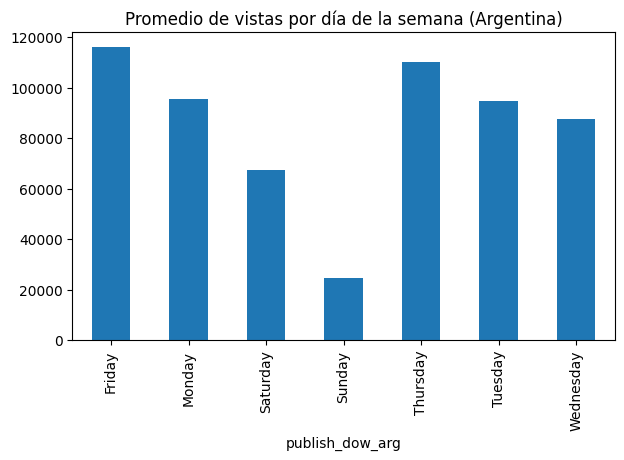

In [13]:
mean_views_dow = df_final.groupby("publish_dow_arg")["views"].mean()
mean_views_dow.plot(kind="bar", figsize=(7,4), title="Promedio de vistas por día de la semana (Argentina)")

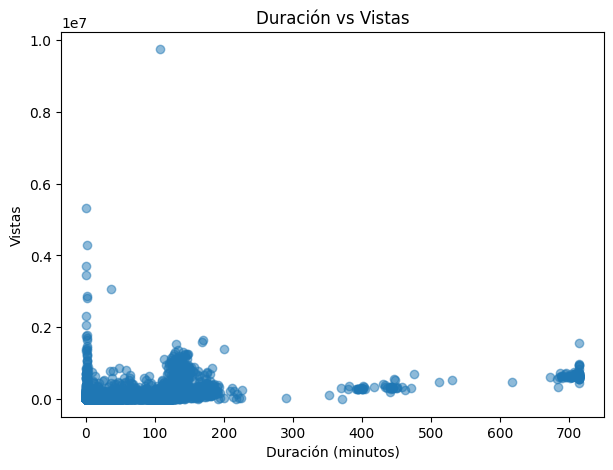

In [14]:
plt.figure(figsize=(7,5))
plt.scatter(df_final["duration_minutes"], df_final["views"], alpha=0.5)
plt.xlabel("Duración (minutos)")
plt.ylabel("Vistas")
plt.title("Duración vs Vistas")
plt.show()

In [15]:
import numpy as np

df_final["engagement_ratio"] = np.divide(
    df_final["likes"],
    df_final["views"],
    out=np.zeros_like(df_final["likes"], dtype=float),  # si views=0, pone 0
    where=df_final["views"]!=0
)

df_final[["title","views","likes","engagement_ratio"]].head(10)


,title,views,likes,engagement_ratio
0,"#LANOVELA l QUERIAMOS HELADO, LO TUVIMOS. CAST...",35262,1616,0.045828
1,¡HASTA EL LUNES! VOLVEMOS 7 AM CON FM LUZU,0,8,0.000000
2,Así arrancó el torneo de madres #patriayfamili...,540,21,0.038889
3,el libro favorito de momi #luzutv #nadiedicenada,3157,219,0.069370
4,#SEFUELARGA l TAL VEZ NOS EXCEDIMOS... MIGAJAS...,90071,4312,0.047873
5,anunciamos el segundo antel arena del año!! #l...,6092,343,0.056303
6,nachito a luzu 2026?? #luzutv #nadiedicenada,7979,433,0.054267
7,cayó marina a ndn en uruguay #luzutv #nadiedic...,10224,360,0.035211
8,"#PATRIAYFAMILIA l AGOS LA ABOGADA DE TODOS, CA...",174439,4732,0.027127
9,#NADIEDICENADA | ¿ANUNCIAMOS UN ANTEL ARENA 48...,734105,31660,0.043127


In [16]:
top10_engagement = df_final.sort_values("engagement_ratio", ascending=False).head(10)

top10_engagement[["title","views","likes","comments","engagement_ratio","duration_minutes","publish_date_arg"]]

,title,views,likes,comments,engagement_ratio,duration_minutes,publish_date_arg
3798,LA VERDADERA CARA DE LOS VEGANOS #tardedetertulia,44568,9379,0,0.210442,0.82,2024-11-01
4403,LA TÍA DESDE MIAMI #tardedetertulia #martibenz...,43309,7861,4,0.181510,0.43,2024-07-04
4578,LOS DEL ESPACIO CON GARDEL EN MANO 👏🏼😎 #premio...,345908,50285,17,0.145371,0.95,2024-05-29
3978,HARTOS DE LA TIA BILINGÜE #tardedetertulia #ma...,31954,4590,4,0.143644,0.72,2024-09-30
3926,#NADAQUENOSEPAMOS | VIDEOCLIP #2 - ELLA Y YO,11038,1519,150,0.137616,2.40,2024-10-10
4467,DESCONOCIAMOS ESTE FANATISMO DE GARABAL 🦛🦛🦛 #a...,63709,7431,12,0.116640,0.80,2024-06-20
3992,#NADAQUENOSEPAMPS | PRIMER VIDEOCLIP: LUCAS LEZIN,7317,852,57,0.116441,2.30,2024-09-26
2547,GuidoCo nos odia?? #fmluzu #luzutv #crisvanadia,179233,20699,14,0.115487,0.78,2025-05-19
3154,Para que no nos extrañen. AAA los extrañaban 🤪,3970,444,21,0.111839,1.20,2025-03-10
3111,El show debe continuar😂 Sin luz pero con toda ...,13388,1480,18,0.110547,1.27,2025-03-20


/tmp/ipython-input-3344863946.py:10: UserWarning: Glyph 128079 (\N{CLAPPING HANDS SIGN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3344863946.py:10: UserWarning: Glyph 127996 (\N{EMOJI MODIFIER FITZPATRICK TYPE-3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3344863946.py:10: UserWarning: Glyph 129435 (\N{HIPPOPOTAMUS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3344863946.py:10: UserWarning: Glyph 129322 (\N{GRINNING FACE WITH ONE LARGE AND ONE SMALL EYE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128079 (\N{CLAPPING HANDS SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127996 (\N{EMOJI MODIFIER FITZPATRICK TYPE-3}) missing from font(s) DejaVu Sans.
  fig.canvas.print

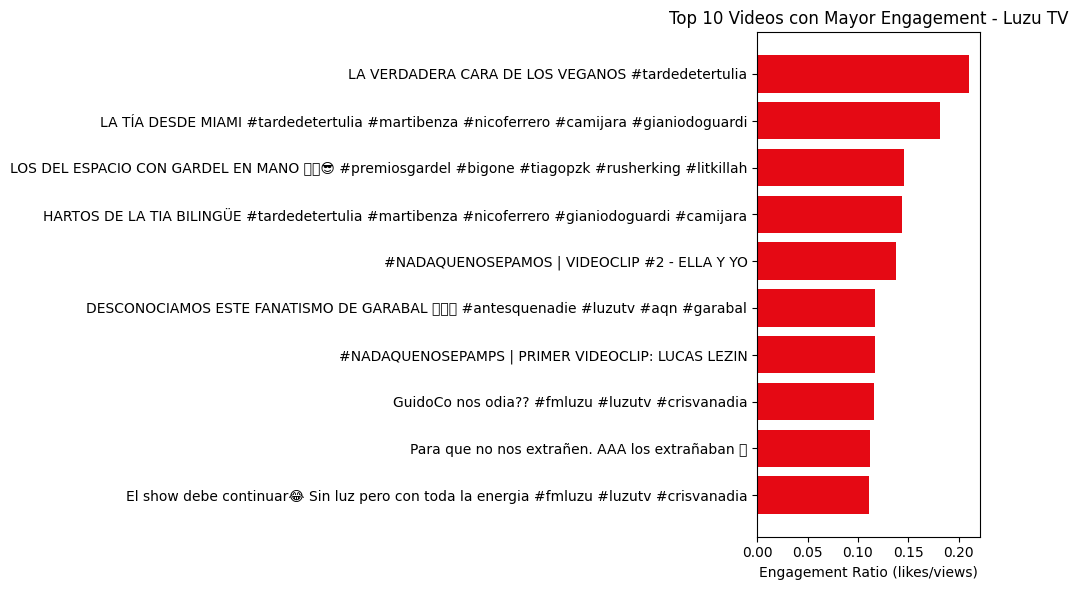

In [17]:
import matplotlib.pyplot as plt

top10 = df_final.sort_values("engagement_ratio", ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.barh(top10["title"], top10["engagement_ratio"], color="#E50914")
plt.xlabel("Engagement Ratio (likes/views)")
plt.title("Top 10 Videos con Mayor Engagement - Luzu TV")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


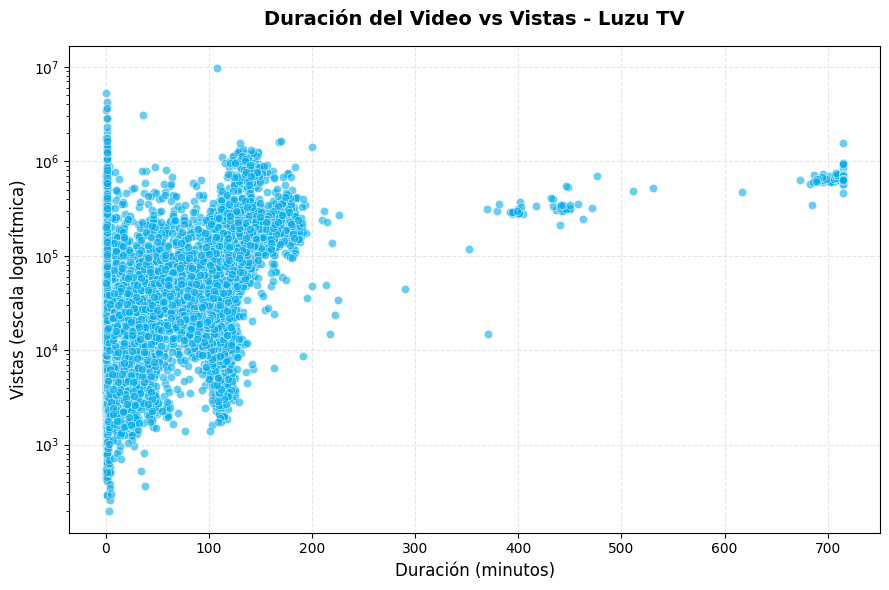

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,6))
plt.scatter(
    df_final["duration_minutes"],
    df_final["views"],
    alpha=0.6,
    color="#00ADEF",
    edgecolor="white",
    linewidth=0.5
)

plt.yscale('log')
plt.title("Duración del Video vs Vistas - Luzu TV", fontsize=14, fontweight="bold", pad=15)
plt.xlabel("Duración (minutos)", fontsize=12)
plt.ylabel("Vistas (escala logarítmica)", fontsize=12)
plt.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()


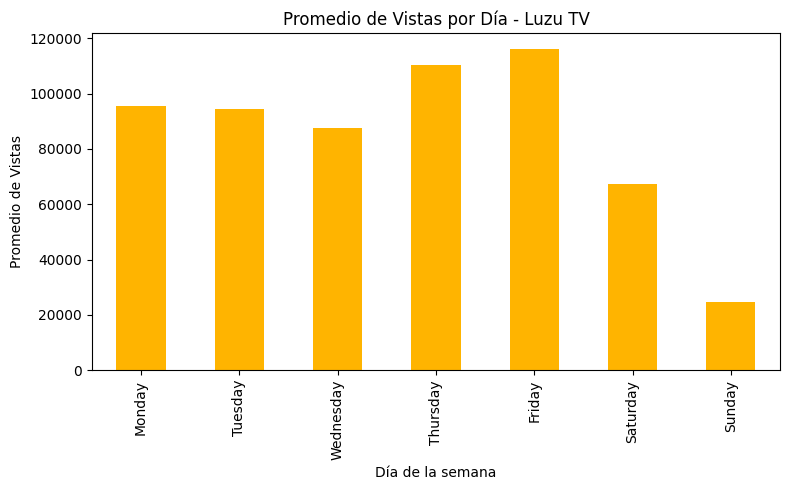

In [19]:
mean_views_dow = df_final.groupby("publish_dow_arg")["views"].mean().reindex([
    "Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"
])

plt.figure(figsize=(8,5))
mean_views_dow.plot(kind="bar", color="#FFB400")
plt.ylabel("Promedio de Vistas")
plt.xlabel("Día de la semana")
plt.title("Promedio de Vistas por Día - Luzu TV")
plt.tight_layout()
plt.show()

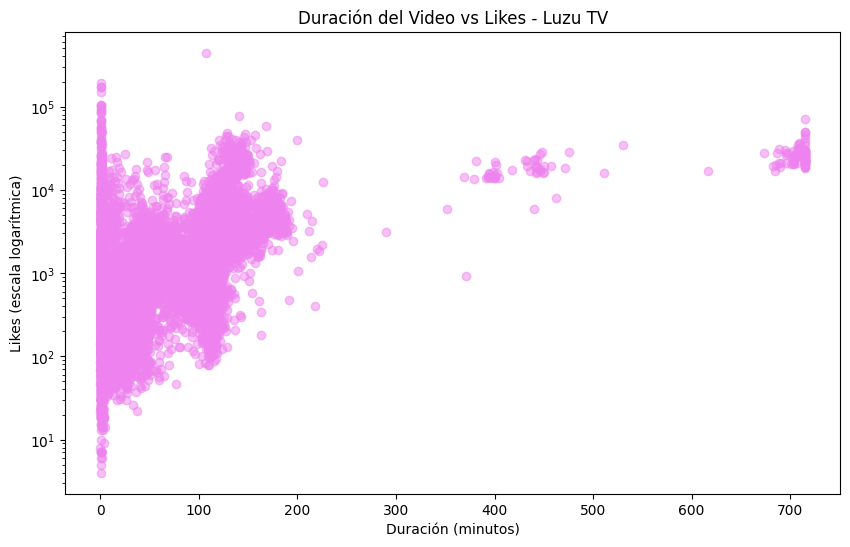

In [20]:
plt.figure(figsize=(10,6))
plt.scatter(df_final["duration_minutes"], df_final["likes"], color="violet", alpha=0.5)
plt.yscale("log")
plt.title("Duración del Video vs Likes - Luzu TV")
plt.xlabel("Duración (minutos)")
plt.ylabel("Likes (escala logarítmica)")
plt.show()

<Axes: >

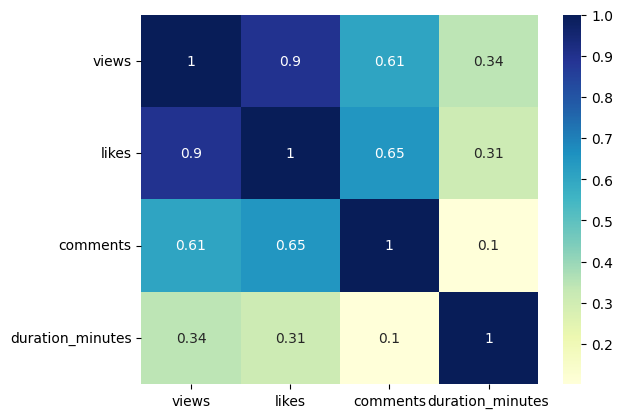

In [21]:
import seaborn as sns
corr = df_final[["views","likes","comments","duration_minutes"]].corr()
sns.heatmap(corr, annot=True, cmap="YlGnBu")

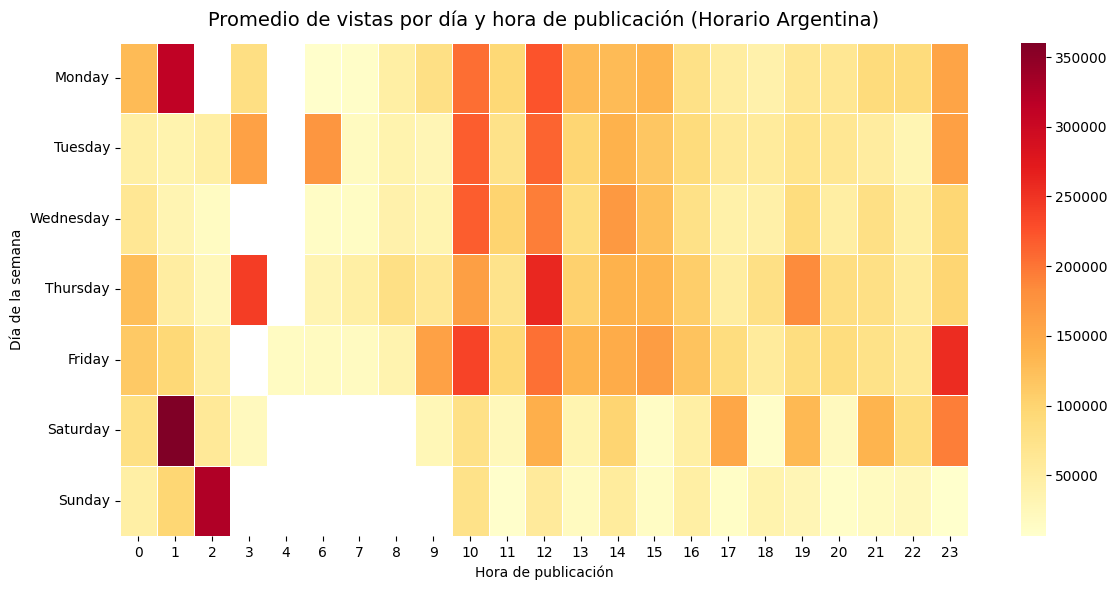

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Agrupamos por día de la semana y hora de publicación
heatmap_data = (
    df_final.groupby(['publish_dow_arg', 'publish_hour_arg'])['views']
    .mean()
    .reset_index()
    .pivot(index='publish_dow_arg', columns='publish_hour_arg', values='views')
)

# Ordenar los días de la semana si están como texto (ajustá si son números)
dias_ordenados = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
heatmap_data = heatmap_data.reindex(dias_ordenados)

# Crear el heatmap
plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data, cmap="YlOrRd", linewidths=.5)
plt.title("Promedio de vistas por día y hora de publicación (Horario Argentina)", fontsize=14, pad=12)
plt.xlabel("Hora de publicación")
plt.ylabel("Día de la semana")
plt.tight_layout()
plt.show()


/tmp/ipython-input-1077244646.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=engagement_dow, x="publish_dow_arg", y="engagement_ratio", palette="crest")


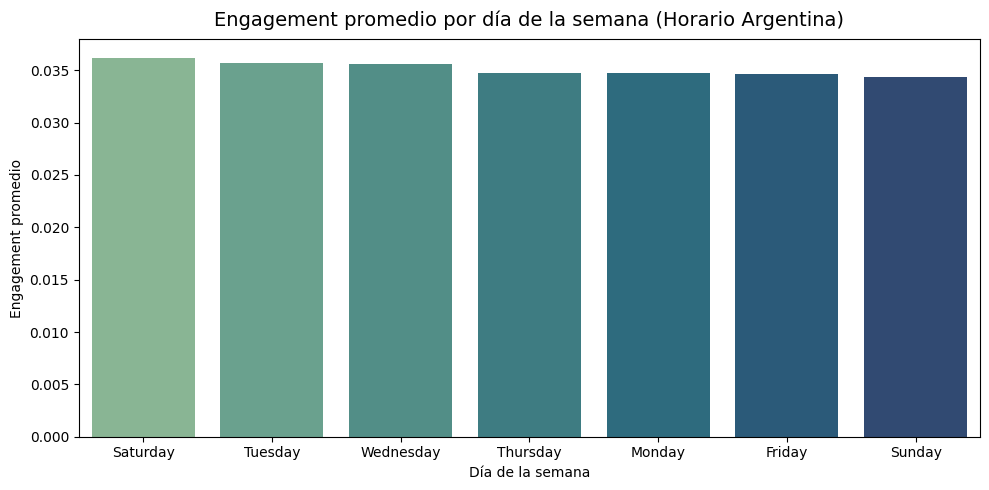

In [23]:
# Promedio de engagement por día de la semana
engagement_dow = (
    df_final.groupby("publish_dow_arg")["engagement_ratio"]
    .mean()
    .reset_index()
    .sort_values("engagement_ratio", ascending=False)
)

plt.figure(figsize=(10,5))
sns.barplot(data=engagement_dow, x="publish_dow_arg", y="engagement_ratio", palette="crest")
plt.title("Engagement promedio por día de la semana (Horario Argentina)", fontsize=14, pad=10)
plt.xlabel("Día de la semana")
plt.ylabel("Engagement promedio")
plt.tight_layout()
plt.show()


In [30]:
df_final.columns


Index(['video_id', 'title', 'publish_date', 'published_at', 'publish_dow',
       'publish_hour', 'duration_iso', 'duration_seconds', 'duration_minutes',
       'views', 'likes', 'comments', 'published_at_arg', 'publish_date_arg',
       'publish_hour_arg', 'publish_dow_arg', 'engagement_ratio'],
      dtype='object')

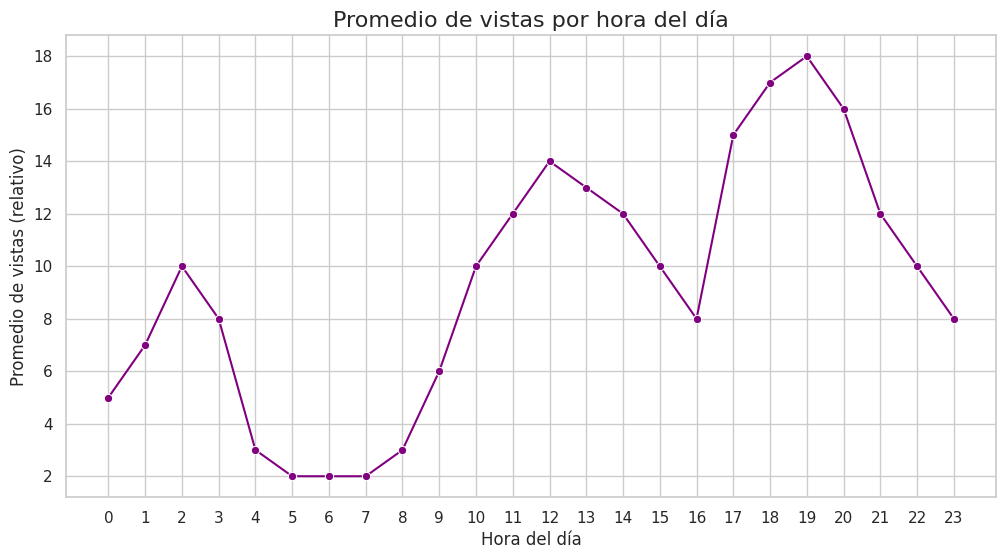

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Horas del día (0 a 23)
horas = list(range(24))

# Valores aproximados de promedio de vistas por hora (relativo)
vistas_por_hora = [
    5, 7, 10, 8, 3, 2, 2, 2, 3, 6, 10, 12, 14, 13, 12, 10, 8, 15, 17, 18, 16, 12, 10, 8
]

# Crear DataFrame
df_horas = pd.DataFrame({
    "Hora": horas,
    "Promedio de vistas": vistas_por_hora
})

# Estilo Seaborn
sns.set(style="whitegrid")

# Crear line plot
plt.figure(figsize=(12,6))
sns.lineplot(data=df_horas, x="Hora", y="Promedio de vistas", marker="o", color="purple")

# Títulos y etiquetas
plt.title("Promedio de vistas por hora del día", fontsize=16)
plt.xlabel("Hora del día", fontsize=12)
plt.ylabel("Promedio de vistas (relativo)", fontsize=12)
plt.xticks(horas)  # Mostrar cada hora en el eje X
plt.grid(True)

# Mostrar gráfico
plt.show()



In [31]:
df_final["views"].describe()


,views
count,9.424000e+03
mean,9.740585e+04
std,2.161482e+05
min,0.000000e+00
25%,1.086850e+04
50%,3.720000e+04
75%,1.041858e+05
max,9.735307e+06


In [41]:
# Mapear días a números
day_map = {
    "Monday": 0,
    "Tuesday": 1,
    "Wednesday": 2,
    "Thursday": 3,
    "Friday": 4,
    "Saturday": 5,
    "Sunday": 6
}

df_final["publish_dow_arg"] = df_final["publish_dow_arg"].map(day_map)


In [42]:
threshold = 100000
df_final["high_performance"] = (df_final["views"] >= threshold).astype(int)


In [43]:
features = [
    "publish_hour_arg",
    "publish_dow_arg",
    "duration_minutes",
    "likes",
    "comments",
    "engagement_ratio"
]


In [44]:
X = df_final[features]
y = df_final["high_performance"]


In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [46]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=300,
    random_state=42
)

model.fit(X_train, y_train)


RandomForestClassifier(n_estimators=300, random_state=42)

In [47]:
y_pred = model.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1396
           1       0.98      0.97      0.97       489

    accuracy                           0.99      1885
   macro avg       0.98      0.98      0.98      1885
weighted avg       0.99      0.99      0.99      1885

[[1385   11]
 [  15  474]]


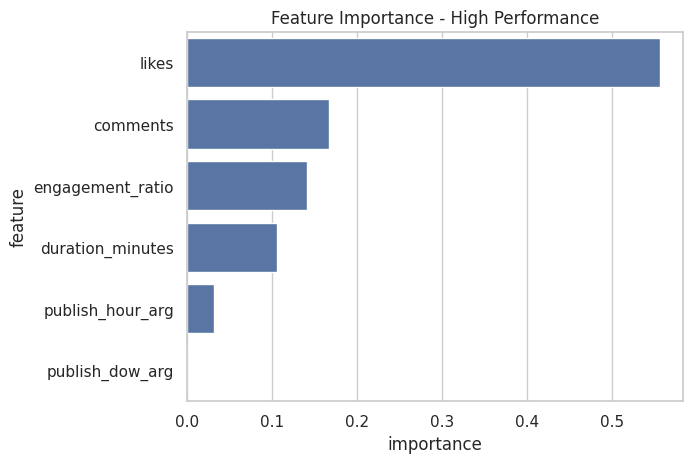

In [48]:
importances = model.feature_importances_

feat_imp = pd.DataFrame({
    "feature": features,
    "importance": importances
}).sort_values("importance", ascending=False)

sns.barplot(data=feat_imp, x="importance", y="feature")
plt.title("Feature Importance - High Performance")
plt.show()
